# Synthesis - Day 1
In today's lecture, we are going to review some of the synthesis techniques, we covered in Intro to Audio Tech I.


In [2]:
import numpy as np
from IPython.display import Audio
#%run hide_toggle.ipynb
from scipy.io.wavfile import read
from scipy import signal
import matplotlib.pyplot as plt


## Additive Synthesis

When we create new sounds out of the *addition* of basic sinusoids, that's called additive synthesis. Let's review some basic "recipes" for some familiar waveforms that are the result of basic additive synthesis. That is, we'll build everything by combining simple sinusoids.

Recall the basic formula for a real-valued sinusoid:

$$ A\ sin(\omega_{0}t + \phi)$$




In [3]:
A = 1
fs = 44100
f0 =20
dur = 1
t = np.arange(0, fs*dur) # time in samples
phi = np.pi/2
# divided out by fs.
tone = A * np.sin(2*np.pi*f0*t/fs + dur)

In [6]:
def genSine(f, t=1, A=1, phi=0, fs=44100):
    # t acting as dur here
    return A * np.sin(2*np.pi * f * np.arange(0, t, 1/fs) + phi)


In [ ]:
# Might not always want sample rate to be default
# Or to have it without returning it is weird
# use object instead
plt.plot(genSine(261))

To perform additive synthesis, we can just add our *equal size* numpy signal arrays

In [9]:
# plt.subplot(3,1,1) # 3 vrtical plots
# plt.tight_layout()
# plt.plot(x[:2000])

x = genSine(261)
y = genSine(440)
z = x + y
Audio(x+y, rate=44100)

The resulting audio of two sounds added together will always equal (percpetually) those two independent sounds now sounding simultaneously. (However, if the sinusoids are integer multiples of each other, they may be perceived as a single sound with multiple harmonics.)

# Complex Tones

Remember: a complex tone is any signal that can be described as periodic, and as made up of more than one sinusoidal component. These individual frequencies or sinusoidal components are called partials.

## Harmonic signals

* If a complex tone has partials that are related by integer ratios, it is a harmonic signal. 
* The lowest harmonic is called the fundamental frequency and is usually the perceived pitch. 


![Alt text](https://upload.wikimedia.org/wikipedia/commons/b/b7/Harmonic_spectra_theoretical_x_y.png)

## Inharmonic signals

* Inharmonic signals generate complex tones where the partials are not related by integer ratio. 
* E.g.: bells, tympani. Imprecise overall pitch; can have pitch corresponding to dominant partial or even several pitches
*  These generate waveforms that are not clearly periodic, but can still be described as a series of superimposed sinusoids.

In [16]:
from IPython.display import Image
Image(url='https://upload.wikimedia.org/wikipedia/commons/f/f7/Bell_inharmonic_spectrum.png', width=500)

### Noise & Non-Musical Sounds

* E.g., white noise, cymbals
* Dog barking
* Aperiodic signal (random temporal representation - waveform does not clearly repeat). **Does not convey the perception of pitch.**

* Although some sound sources have single-frequency components, most sound sources
produce a very disordered and random waveform of amplitude versus time. 

**ALL complex sounds can be represented as a sum of sinusoidal signals or *components*.** 
The process by which a complex wave is decomposed (broken up) into a set of component sinusoids is referred to as Fourier analysis.

In [14]:
from IPython.display import Image
Image(url="https://hackster.imgix.net/uploads/attachments/537944/image_KipMQodplQ.png?auto=compress%2Cformat&w=1280&h=960&fit=max")

We can create simple "recipes" for the most basic of complex waveforms, which are the combination of specific combinations of a fundamental sinusoid and various integer multiples (in Hz)

Below is a table for comparing a pure tone, and 3 complex (artificial) waveforms, showing which harmonics are present and at which amplitudes:

| Waveshape | a1 | a2 | a3| a4| a5| a6| a7 | a8 | a9 | aN | General Rule |
| ---: | :---: | :---: | :---: | :---: | :---: | :---: | :---: | :---: | :---: |:---: | :------------------: |
| Sine | 1 | 0 | 0 | 0 | 0 |0 | 0 | 0 | 0 | ... | $f0$ only |
| Sawtooth | 1 | 1/2 | 1/3 | 1/4 | 1/5 | 1/6 | 1/7 | 1/8 | 1/9 | ... |$1/x$ |
| Square | 1 | 0 | 1/3 | 0 | 1/5 | 0 | 1/7 | 0 | 1/9 | ... |$1/x$ for odd $x$ |
| Triangle |  1 | 0 | -1/9 | 0 | 1/25 | 0 | -1/49 | 0 | 1/81 | ... |$1/x^2$ for odd $x$, alternating + and - | 

Let's build a sawtooth wave using our genSine() function

In [ ]:
# Stack function stacks arrays.
f0 = 440
n = 4 # 4 harmonics
A = 1

sum(np.stack(genSine(f0*i, A=A/i) for i in range(1, n+1)))

Let's build a saw another way using loops

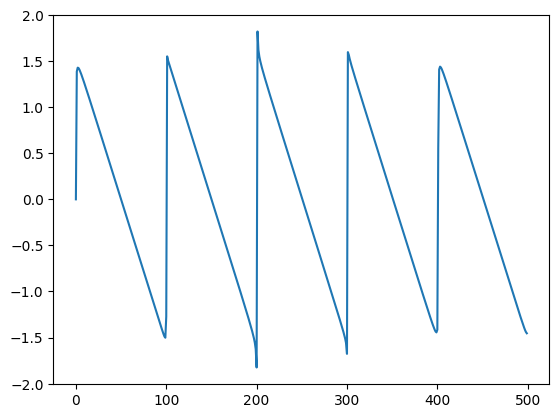

In [21]:
f0 = 440
n = 100
a0 = 1
saw = np.zeros(44100) # a base to add
for i in range(1, n+1):
    s = genSine(f0*i, A=a0/i)
    saw += s

plt.plot(saw[:500])


In [ ]:
# Can enhance that with genSine.
# numpy vectorization going to be faster generally,
# Let's time it with timeit func!
def saw(A, f, T, n):
    # A: amplitude of saw
    # f: freq of saw (Hz)
    # T: period of saw (s)
    # n: number of harmonics
    # x + x/2 + x/3 + ... x/n = A x = A/(1 + 1/2 + 1/3 + ...  1/n)
    # out: saw wavetable (t, saw)
    # Makes A amplitude of saw
    # I wonder if you could divide out by a factor at the end instead.
    a = A/sum(1/i for i in range(1, n+1))
    
    waves = [genSine(f*i, A=a/i) for i in range(1, n+1)]
    # sum along vertical axis
    return (np.sum(np.stack(waves), axis=0))

plt.plot(saw(1, 440, 1))

Let's do it again using numpy functions and a zipped for loop

In [24]:
%%timeit
f0 = 440
a0 = 1
n = 10
# Oh right no need for list comprehension
# Less memory efficient here too.
mults = np.arange(1, n+1)
freqs = list(mults*f0)
amps = list(a0/mults)
saw = np.stack([genSine(f, A=a) for (f,a) in zip(freqs, amps)])
saw = np.sum(saw, axis=0)
# zip unpacks two lists and returns tuple of values

# Jupytr has magic function. 

np.stack?

11.7 ms ± 4.38 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Signature: np.stack(arrays, axis=0, out=None)
Docstring:
Join a sequence of arrays along a new axis.

The ``axis`` parameter specifies the index of the new axis in the
dimensions of the result. For example, if ``axis=0`` it will be the first
dimension and if ``axis=-1`` it will be the last dimension.

.. versionadded:: 1.10.0

Parameters
----------
arrays : sequence of array_like
    Each array must have the same shape.

axis : int, optional
    The axis in the result array along which the input arrays are stacked.

out : ndarray, optional
    If provided, the destination to place the result. The shape must be
    correct, matching that of what stack would have returned if no
    out argument were specified.

Returns
-------
stacked : ndarray
    The stacked array has one more dimension than the input arrays.

See Also
--------
concatenate : Join a sequence of arrays along an existing axis.
block : Assemble an nd-array from nested lists of blocks.
split : Split array into a list of mul

# Envelopes
In sound and music, an **envelope** describes how a sound changes over time. 

### ADSR

One of the most common kinds of envelopes for modeling "real" sounds has four components: Attack, Decay, Sustain, Release.

Remember:
The attack, decay, and release are all technically **time parameters** while sustain is a **level parameter**.  

A --> The attack is the amount of time from sound onset (e.g., key strike) to peak amplitude  
D --> The decay is the amount of time to descend from the peak amplitude to the sustain level  
S --> Level of sustain  
R --> Time from sound offset (e.g., key release) to zero amplitude.

Since ADSR envelopes describe how the basic outline of a sound's amplitude varies *over time*, ADSR is a type of *temporal envelope*


In [26]:
from IPython.display import Image, Audio
Image('../AudioTechII/images/ADSR.jpg', width = 600, embed=True)

FileNotFoundError: No such file or directory: '../AudioTechII/images/ADSR.jpg'

FileNotFoundError: No such file or directory: '../AudioTechII/images/ADSR.jpg'

<IPython.core.display.Image object>

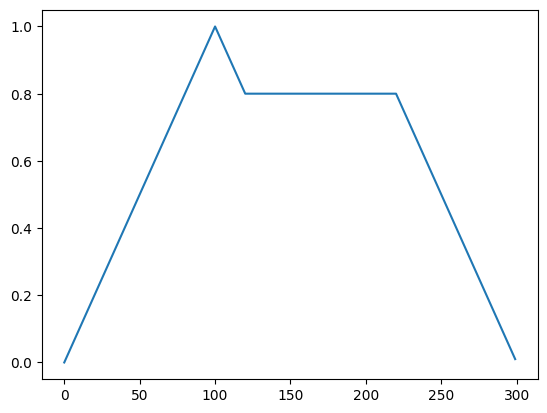

In [27]:
a = np.arange(0, 100)
d = np.arange(100, 80, -1)
s = np.full(100, 80) # 100 80's
r = np.arange(80, 0, -1)
env = np.concatenate((a,d,s,r))/100
plt.plot(env)

We can apply amplitude envelopes to audio in Python by multiplying our original audio array with an array containing the envelope. 

The length of your amplitude envelope must be the same size as your original audio file

In [32]:
fs = 44100
x = genSine(440)
# remember default fs = 44100 and dur is 1 default
# in time
a_samps = int(0.2 * fs)
d_samps = int(0.1 * fs)
s_samps = int(0.5 * fs)
r_samps = int(0.2 * fs)
# could put this in arr by specified times.


s_level = 0.8 ## uncomplicated
a = np.linspace(0, 1, a_samps)
d = np.linspace(1, s_level, d_samps)
s = np.full(s_samps, s_level)
r = np.linspace(s_level, 0, r_samps)
env = np.concatenate((a, d, s, r))
len(env)

# lin space is also double counting samples due to its nature

44100

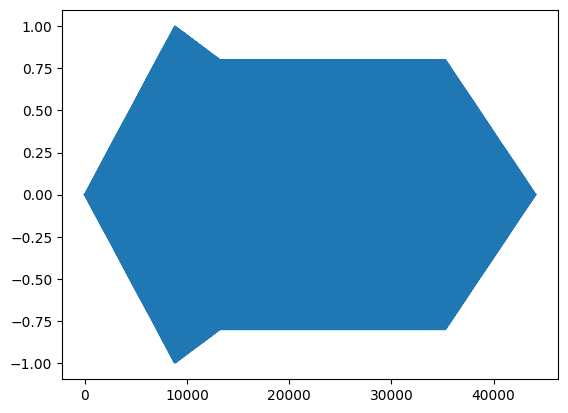

In [33]:
plt.plot(x*env)
# I didn't realize amp envelopes look like  this on bipolar sin.

## Modulation - Amplitude LFOs

Just like an envelope function, we can modify one signal by multiplying it with another which will affect its amplitude over time. So a naturally smooth, time-varying signal like a sinusoid is great for creating a tremolo-like effect. 
One way of achieving this is with an LFO (low frequency oscillator)

For amplitude modulation - we will multiply the carrier and the modulator signals

$$s(t) = (1 + m(t)) \times A_c\sin(2\pi f_c t)$$
...where $A_c$ is the carrier amplitude, 1 is the DC offset, and $m(t)$ is the modulator signal.

The modulator is always a periodic or quasi-periodic oscillator, with a clearly defined frequency, waveshape, and amplitude.
By taking a signal oscillating at a very low frequency, and using that as our modulator frequency, we can alter a carrier signal's amplitude in a regular way. This is known as an LFO.

* The frequency of the modulator affects the rate of change of the carrier's amplitude. I.e., increasing the frequency of the modulator will increase the tremolo effect in the modulated signal.

* The amplitude (or modulator index) of the modulator affects the *depth* of change of the carrier's amplitude

* The shape of the modulator affects the regular time-varying amplitude shapes in the carrier's amplitude

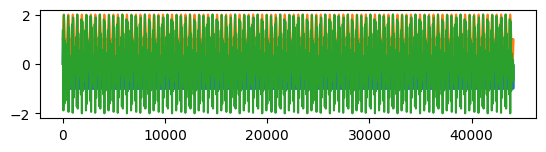

In [38]:
# unipolar modulator AM
carrier = genSine(440)
modulator = 1 + genSine(100)

# Can we calculate the beating by difference of the freqs?
# c +- m - c = +- m
out = carrier * modulator
plt.subplot(3, 1, 2)
plt.plot(carrier)
plt.plot(modulator)
plt.plot(out)
Audio(out, rate=44100)

The modulator can be any periodic signal (or waveform), and the carrier can be any incoming signal.
Let's try with a square lfo on a loaded audio file

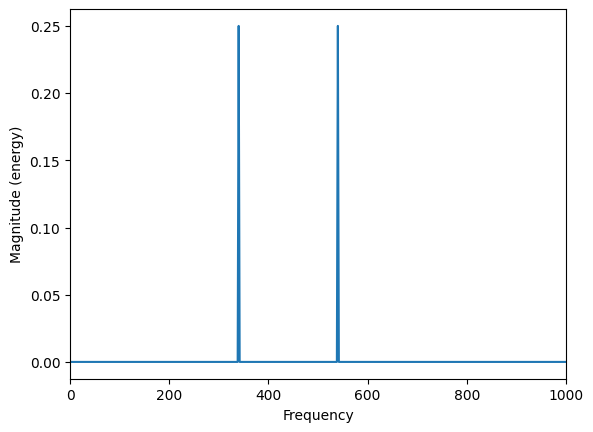

In [44]:
# Is it that we increased it, or are they always there?
plt.magnitude_spectrum(out, Fs=44100) # very cool!
plt.xlim([0, 1000])
plt.show()

## AM Synthesis

If we increase the frequency of the modulator, we create a new complex sound with additional frequency components. 

Recall with modulators above 20 Hz, we will get sidebands at carrier_freq $\pm$ modulator_freq along with a "preserved" carrier.

## Ring modulation

Ring modulation is the same as amplitude modulation, but it specifically uses 2 bipolar signals. 

Notice this affects the magnitude of the sidebands and the presence of the carrier frequency in the final signal.

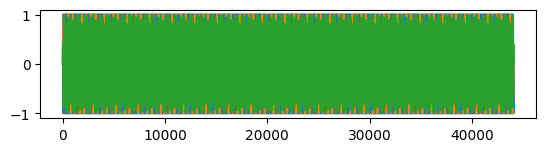

In [41]:
carrier = genSine(440)
modulator = genSine(100)

# Can we calculate the beating by difference of the freqs?
# c +- m - c = +- m
out = carrier * modulator
plt.subplot(3, 1, 2)
plt.plot(carrier)
plt.plot(modulator)
plt.plot(out)
Audio(out, rate=44100)